In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import csv
import math
import json
from scipy.ndimage import uniform_filter1d
from tqdm import tqdm
import pandas as pd, datetime
import time

from utils import *
from autoencoder_networks import *
from diffusion_networks import *
from sampler import *
from calculations import *
from loss import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cmap = plt.cm.get_cmap('viridis', 30)

# **Data Loading**

## QG

In [3]:
# QG Dataset

batch_size = 64 # 256 Largest possible batch size that fits on the GPU w.f32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean_data = 0.003394413273781538
std_data = 9.174626350402832
norm_factors = (mean_data, std_data)

iterations = 2101000
spinup = 1001
spacing = 150
p_train = 0.8

n_samples = iterations+1
n_train = int(np.round(p_train * (n_samples - spinup)))  # Number of training samples
n_val = int(np.round((1 - p_train) / 2 * (n_samples - spinup)))  # Number of validation samples
sample_counts = (n_samples, n_train, n_val)

on_remote = False
fname= f'QG_samples_SUBS_{iterations}.npy'
subd = 'C:/Users/svart/Desktop/MEX/data/'
if on_remote:
    subd = '/nobackup/smhid20/users/sm_maran/dpr_data/simulations'
dataset_path = Path(f'{subd}/{fname}')


grid_dimensions = (65, 65)
max_lead_time = 150

QG_kwargs = {
            'dataset_path':     dataset_path,
            'sample_counts':    sample_counts,
            'grid_dimensions':  grid_dimensions,
            'max_lead_time':    max_lead_time,
            'norm_factors':     norm_factors,
            'device':           device,
            'spinup':           spinup,
            'spacing':          spacing,
            'dtype':            'float32'
            }

In [4]:
# Way to load a dataset with a specific lead time
train_dataset = QGDataset(lead_time=100, dataset_mode='train', **QG_kwargs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Way to load a dataset with a specific lead time
val_dataset = QGDataset(lead_time=150, dataset_mode='val', **QG_kwargs)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Way to load a dataset with a specific lead time
test_dataset = QGDataset(lead_time=150, dataset_mode='test', **QG_kwargs)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Way to load a dataset with lead time following a distribution given by update_k_per_batch
update_k_per_batch = get_uniform_k_dist_fn(kmin=1, kmax=150, d=1)

train_time_dataset = QGDataset(lead_time=max_lead_time, dataset_mode='train', **QG_kwargs)
train_batch_sampler = DynamicKBatchSampler(train_time_dataset, batch_size=batch_size, drop_last=True, k_update_callback=update_k_per_batch, shuffle=True)
train_time_loader = DataLoader(train_time_dataset, batch_sampler=train_batch_sampler)

# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 50
t_kmax = 150
t_d = 50
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **QG_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

In [5]:
precomputed_std = torch.tensor(np.loadtxt('stds.txt',delimiter=' ')[:,1], dtype=torch.float32).to(device)
def residual_scaling(x):
    return precomputed_std[x.to(dtype=int)-1]

### QG NWP comparison

In [ ]:
# Numerical model
n_val = 210000

#nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy')
nwp_data_path = Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_Test_{iterations}_n_{n_val}_k_{k}.npy')

nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Fixed k sampling
kmin = 1
kmax = 150
d = 1

nwp_data_path = Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_Test_2101000_n_210000_1_k_150.npy')

nwp_time_series_dataset = NWPTimeSeriesDataset(nwp_data_path, 'val', p_train, kmin, kmax, d, spinup, spacing, 210000, mean_data, std_data, device, dtype='float64', offset=2**7)
nwp_time_series_loader = DataLoader(nwp_time_series_dataset, batch_size=1, shuffle=False)

## WB

In [6]:
# WB Dataset

batch_size = 64 # 256 Largest possible batch size that fits on the GPU w.f32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
offset = 2**7

mean_data = 54112.887 
std_data = 3354.9524
norm_factors = (mean_data, std_data)

spacing = 10
spinup = 0
ti = pd.date_range(datetime.datetime(1979,1,1,0), datetime.datetime(2018,12,31,23), freq='1h')
n_train = sum(ti.year <= 2015)
n_val = sum((ti.year >= 2016) & (ti.year <= 2017))
n_samples = len(ti)
sample_counts = (n_samples, n_train, n_val)

on_remote = False
fname= 'geopotential_500hPa_1979-2018_5.625deg.npy'
subd = 'C:/Users/svart/Desktop/MEX/data/'
if on_remote:
    subd = '/nobackup/smhid20/users/sm_tland/wb1/geopotential_500'
dataset_path = Path(f'{subd}/{fname}')

grid_dimensions = (32, 64)
max_lead_time = 36

WB_kwargs = {
            'dataset_path':     dataset_path,
            'sample_counts':    sample_counts,
            'grid_dimensions':  grid_dimensions,
            'max_lead_time':    max_lead_time,
            'norm_factors':     norm_factors,
            'device':           device,
            'spinup':           spinup,
            'spacing':          spacing,
            'dtype':            'float32',
            'offset':           offset
            }

In [7]:
# Way to load a dataset with a specific lead time
lead_time = 1
train_dataset = QGDataset(lead_time=lead_time,dataset_mode='train', **WB_kwargs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Way to load a dataset with a specific lead time
val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **WB_kwargs)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Way to load a dataset with lead time following a distribution given by update_k_per_batch
kmin = 1
kmax = 36
d = 1

update_k_per_batch = get_uniform_k_dist_fn(kmin, kmax, d)

train_time_dataset = QGDataset(lead_time=kmax, dataset_mode='train', **WB_kwargs)
train_batch_sampler = DynamicKBatchSampler(train_time_dataset, batch_size=batch_size, drop_last=True, k_update_callback=update_k_per_batch, shuffle=True)
train_time_loader = DataLoader(train_time_dataset, batch_sampler=train_batch_sampler)

In [49]:
# Way to load a single trajectory. Only uses 1 batch.
kmin = 50
kmax = 150
d = 50
k_series = kmin + d * np.arange(0, 1 + (kmax-kmin)//d)

val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **WB_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

In [9]:
precomputed_std = torch.tensor(np.loadtxt('WB_stds.txt',delimiter=' ')[:,1], dtype=torch.float32).to(device)
def residual_scaling(x):
    return precomputed_std[x.to(dtype=int)-1]

# **Autoencoder**

## Training

In [12]:
# Setup for training

lambda_l1 = 0.00001

num_epochs = 10

autoencoder = Autoencoder(filters= 32, no_latent_channels=1, no_downsamples=1, start_kernel=3)

print("Num params: ", sum(p.numel() for p in autoencoder.parameters()))

autoencoder.to(device)

optimizer = optim.AdamW(autoencoder.parameters(), lr=0.01, weight_decay=0.01)
loss_fn = nn.L1Loss()

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=1)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'autoencoder_training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

Num params:  23330


In [13]:
autoencoder.load_state_dict(torch.load('best_ae.pth'))

<All keys matched successfully>

  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:08<00:00,  7.52it/s]


Average Loss: 0.2321


100%|██████████| 4/4 [00:00<00:00, 15.34it/s]


Epoch [1/10], Average Loss: 0.2321, Validation Loss: 0.1585


100%|██████████| 64/64 [00:08<00:00,  7.70it/s]


Average Loss: 0.0952


100%|██████████| 4/4 [00:00<00:00, 14.99it/s]


Epoch [2/10], Average Loss: 0.0952, Validation Loss: 0.0782


100%|██████████| 64/64 [00:08<00:00,  7.36it/s]


Average Loss: 0.0695


100%|██████████| 4/4 [00:00<00:00, 12.81it/s]


Epoch [3/10], Average Loss: 0.0695, Validation Loss: 0.0992


100%|██████████| 64/64 [00:10<00:00,  6.08it/s]


Average Loss: 0.0616


100%|██████████| 4/4 [00:00<00:00, 11.54it/s]


Epoch [4/10], Average Loss: 0.0616, Validation Loss: 0.0643


100%|██████████| 64/64 [00:11<00:00,  5.63it/s]


Average Loss: 0.0539


100%|██████████| 4/4 [00:00<00:00, 11.28it/s]


Epoch [5/10], Average Loss: 0.0539, Validation Loss: 0.0584


100%|██████████| 64/64 [00:11<00:00,  5.65it/s]


Average Loss: 0.0483


100%|██████████| 4/4 [00:00<00:00, 11.08it/s]


Epoch [6/10], Average Loss: 0.0483, Validation Loss: 0.0455


100%|██████████| 64/64 [00:11<00:00,  5.61it/s]


Average Loss: 0.0434


100%|██████████| 4/4 [00:00<00:00, 10.97it/s]


Epoch [7/10], Average Loss: 0.0434, Validation Loss: 0.0466


100%|██████████| 64/64 [00:11<00:00,  5.64it/s]


Average Loss: 0.0407


100%|██████████| 4/4 [00:00<00:00, 10.94it/s]


Epoch [8/10], Average Loss: 0.0407, Validation Loss: 0.0400


100%|██████████| 64/64 [00:11<00:00,  5.64it/s]


Average Loss: 0.0396


100%|██████████| 4/4 [00:00<00:00, 10.24it/s]


Epoch [9/10], Average Loss: 0.0396, Validation Loss: 0.0392


100%|██████████| 64/64 [00:11<00:00,  5.64it/s]


Average Loss: 0.0388


100%|██████████| 4/4 [00:00<00:00, 11.14it/s]


Epoch [10/10], Average Loss: 0.0388, Validation Loss: 0.0389


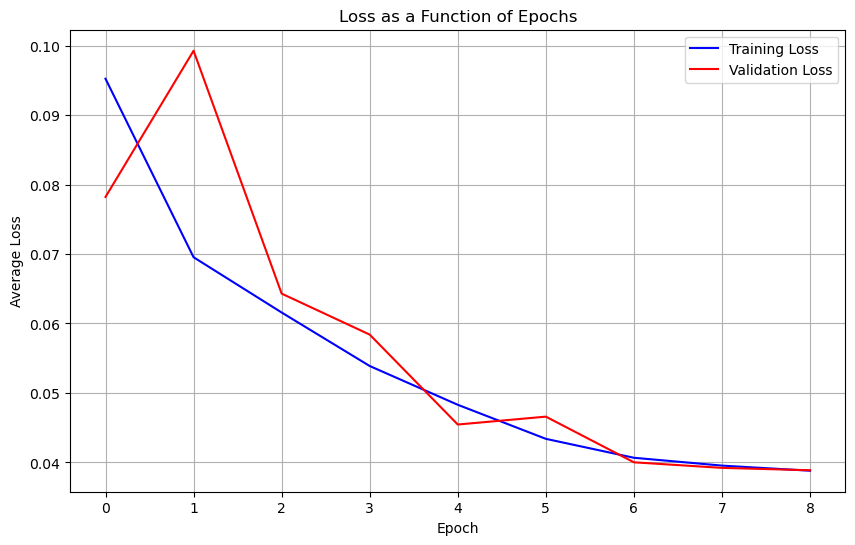

In [35]:
log_interval = 1 + len(train_loader) // 1

for epoch in range(num_epochs):
    autoencoder.train()
    total_train_loss = 0
    current_loss = 0
    count = 0

    for previous, _, _ in tqdm(train_loader):
        previous = previous.to(device)
        
        count += 1
        optimizer.zero_grad()
        
        reconstruction, latent = autoencoder(previous)

        reconstruction_loss = loss_fn(reconstruction, previous)
        latent_loss = lambda_l1 * torch.mean(torch.norm(latent, 1, dim=1))

        loss = reconstruction_loss + latent_loss

        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            current_loss = current_loss / count
            print(f'Average Loss: {current_loss:.4f}')
            current_loss = 0
            count = 0
        
        warmup_scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    autoencoder.eval()
    total_val_loss = 0
    with torch.no_grad():
        for previous, _, _ in tqdm(val_loader):
            previous = previous.to(device)
                        
            reconstruction, latent = autoencoder(previous)

            reconstruction_loss = loss_fn(reconstruction, previous)
            latent_loss = lambda_l1 * torch.mean(torch.norm(latent, 1, dim=1))

            loss = reconstruction_loss + latent_loss
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(autoencoder.state_dict(), 'best_ae.pth')
    
    scheduler.step()
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    torch.save(autoencoder.state_dict(), 'final_ae.pth')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

### Plotting

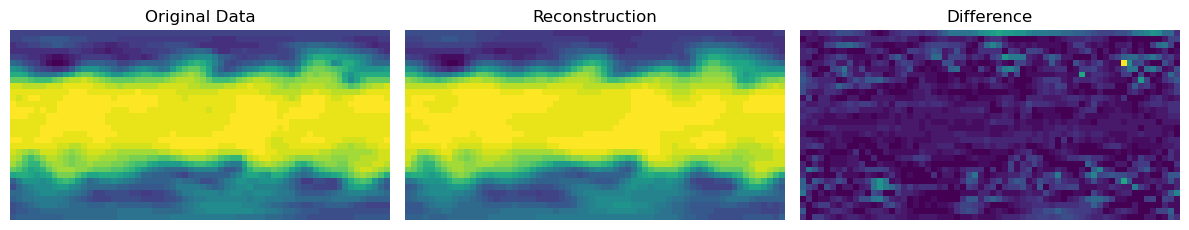

In [15]:
# Create the figure and axes for the subplot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

cmap1 = plt.cm.get_cmap('viridis', 30)

batch,_,_ = next(iter(val_loader))
batch = batch.to(device)
reconstruction, _ = autoencoder(batch)
data = batch[0].cpu().detach().numpy()
axes[0].imshow(data.reshape(grid_dimensions), cmap=cmap1)
axes[0].axis('off')
axes[0].set_title('Original Data')

reconstruction = reconstruction[0].cpu().detach().numpy()
axes[1].imshow(reconstruction.reshape(grid_dimensions), cmap=cmap1)
axes[1].axis('off')

axes[1].set_title('Reconstruction')
diff = np.abs(data - reconstruction)
axes[2].imshow(diff.reshape(grid_dimensions), cmap=cmap1)
axes[2].axis('off')
axes[2].set_title('Difference')

plt.tight_layout()

plt.show()

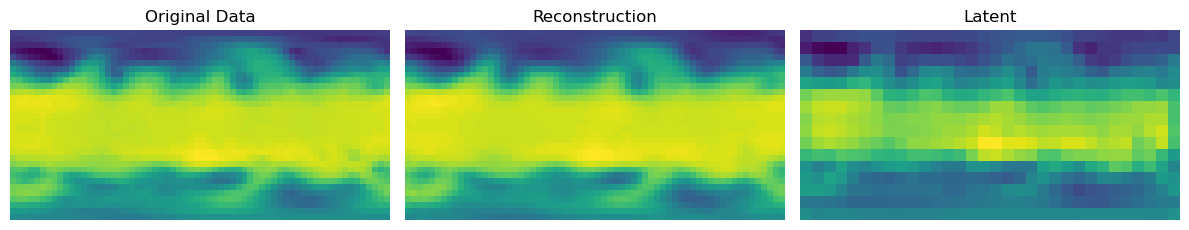

In [16]:
# Create the figure and axes for the subplot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

cmap1 = plt.cm.get_cmap('viridis', 100)

batch,_,_ = next(iter(val_loader))
batch = batch.to(device)
reconstruction, latent = autoencoder(batch)
data = batch[0].cpu().detach().numpy()
axes[0].imshow(data.reshape(grid_dimensions), cmap=cmap1)
axes[0].axis('off')
axes[0].set_title('Original Data')

reconstruction = reconstruction[0].cpu().detach().numpy()
axes[1].imshow(reconstruction.reshape(grid_dimensions), cmap=cmap1)
axes[1].axis('off')
axes[1].set_title('Reconstruction')

latent = latent[0].cpu().detach().numpy()
axes[2].imshow(latent[0], cmap=cmap1)
axes[2].axis('off')
axes[2].set_title('Latent')

plt.tight_layout()

plt.show()

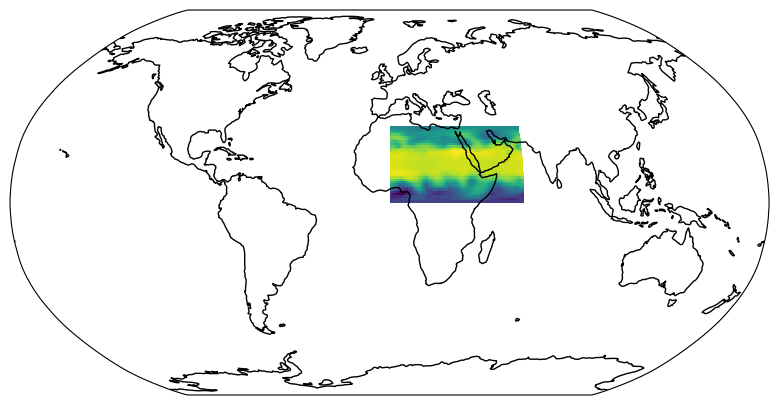

In [35]:
import cartopy.crs as ccrs
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()
#ax.stock_img()
ax.pcolormesh(data.reshape(grid_dimensions), cmap=cmap1, transform=ccrs.PlateCarree())
ax.coastlines()

plt.show()

# **Diffusion**

## **Load Models**

In [12]:
# Load Autoencoder
autoencoder_date = '2024-02-21'
autoencoder_model = 'ae-2ds-32f-1l-150e-L1-0wd-0.00001l1'

autoencoder_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{autoencoder_date}/{autoencoder_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{autoencoder_date}/{autoencoder_model}/')
saved_model = torch.load(autoencoder_path / 'best_model.pth')

with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']

autoencoder = Autoencoder(filters= filters, no_latent_channels=latent_dim, no_downsamples=no_downsamples)
autoencoder.load_state_dict(saved_model)
#autoencoder.to(device)
autoencoder.eval()

print("Autoencoder loaded successfully!")

Autoencoder loaded successfully!


In [7]:
# Load Diffusion model
diffusion_date = '2024-02-29'
result_model = f'ncsnpp-f32-k{k}'

result_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{diffusion_date}/{result_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{diffusion_date}/{result_model}/')
saved_model = torch.load(result_path / 'best_model.pth')

with open(result_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

filters = parameters['filters']
model_name = parameters['model']
k = parameters['k']

forecasting = True
model = GCPrecond(filters=filters, img_channels=2 if forecasting else 1, model='ncsnppOriginal', img_resolution = 16, time_emb=0)

model.load_state_dict(saved_model)
model.to(device)
model.eval()
print("Diffusion Model loaded successfully!")

NameError: name 'k' is not defined

### Scaling function

In [52]:
def calculate_latent_mean_std():
    # Calculate mean and var
    # Initialize variables for mean and standard deviation
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    #autoencoder.to('cpu')
    # Iterate over the batches in train_loader
    autoencoder.eval()
    with torch.no_grad():
        for current, next,_ in train_loader:
            # Get the input data from the batch
            current = current.to(device)
            next = next.to(device)
            latent = autoencoder.encoder(current)
            next_latent = autoencoder.encoder(next)
            
            inputs = next_latent -  latent

            count += inputs.size(0)

            # Calculate the sum of the input data
            mean_data_latent += torch.sum(inputs)
            std_data_latent += torch.sum(inputs ** 2)
            #print(mean_data_latent/count, std_data_latent/count, count)
            break
            
        # Calculate the mean and standard deviation
        count = count * inputs[0].cpu().detach().numpy().size
        # TODO
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)

        # Print the mean and standard deviation
        #print("Mean:", mean_data_latent.item())
        #print("Standard Deviation:", std_data_latent.item())

    return mean_data_latent, std_data_latent

mean_data_latent, std_data_latent = calculate_latent_mean_std()
print(mean_data_latent, std_data_latent)

tensor(-0.0007, device='cuda:0') tensor(0.0965, device='cuda:0')


In [82]:
# Way to load a dataset with a specific lead time
lead_time = 1
train_dataset = QGDataset(lead_time=lead_time,dataset_mode='train', **WB_kwargs)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)

# Fit the residual scaling
ks = np.arange(1, 36, 1)
stds = []
for k in ks:
    train_dataset.set_lead_time(k)

    _, std_latent_k = calculate_latent_mean_std()
    stds.append(std_latent_k.item())
    print(k, std_latent_k.item())

1 0.09547530114650726
2 0.1797654628753662
3 0.2524622678756714
4 0.31211116909980774
5 0.357062965631485
6 0.384503036737442
7 0.39789408445358276
8 0.39937788248062134
9 0.3949809670448303
10 0.39089399576187134
11 0.396379679441452
12 0.41479408740997314
13 0.4470765292644501
14 0.4915032684803009
15 0.5356878638267517
16 0.5763363838195801
17 0.6096087098121643
18 0.6324014067649841
19 0.6476358771324158
20 0.6528350114822388
21 0.6527514457702637
22 0.6505496501922607
23 0.6541801691055298
24 0.6663355231285095
25 0.6917921900749207
26 0.7218554019927979
27 0.7506546378135681
28 0.7815765738487244
29 0.8081163763999939
30 0.8204941153526306
31 0.8322798013687134
32 0.8350961208343506
33 0.8373560905456543
34 0.8340349197387695
35 0.8370303511619568


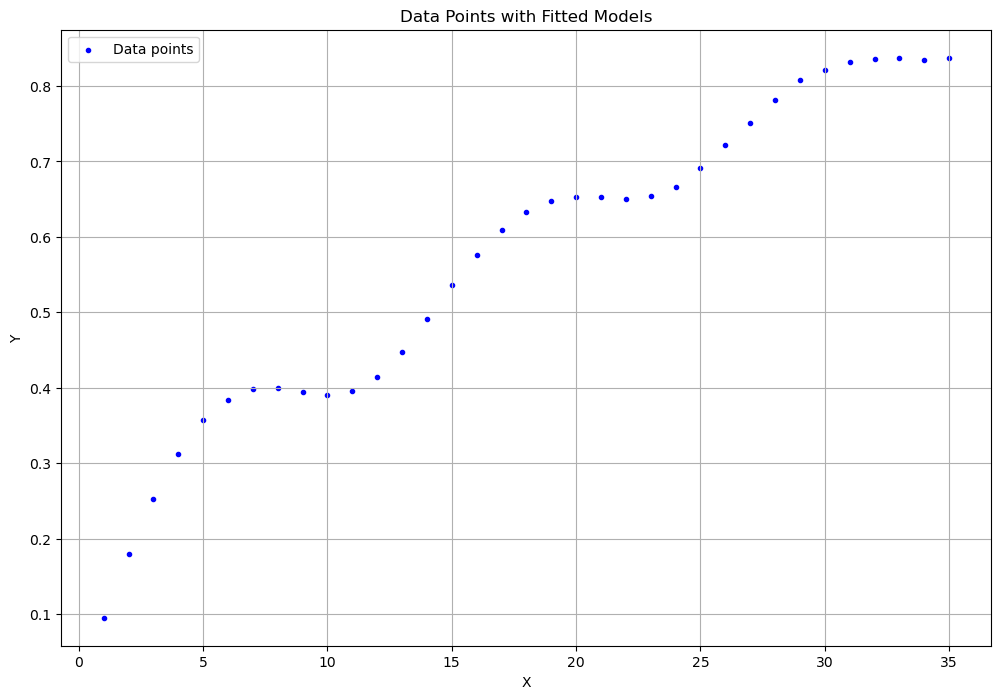

In [83]:
x = ks[:]
y = stds[:]


# Plotting the original data and the fitted models
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color='blue', label='Data points', marker='.')
#plt.plot(x, y_fitted_log, color='red', label='Log Model')
#plt.plot(x, y_fitted_logistic, color='green', label='Logistic Model')
plt.title('Data Points with Fitted Models')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()


## **Training**

In [17]:
# Setup for training

forecasting = True

num_epochs = 10

model = EDMPrecond(filters=32, img_channels=2 if forecasting else 1, img_resolution = 16, time_emb=1, model_type='standard', sigma_data=1, sigma_min=0.02, sigma_max=88)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)
 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
loss_fn = GCLoss(time_noise=0)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=100)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

Num params:  855537


In [8]:
model.load_state_dict(torch.load('models/240414k1-150-100ep.pth'))

<All keys matched successfully>

In [60]:
log_interval = len(train_time_loader) // 10

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    current_loss = 0
    count = 0

    for previous, current, time_label in tqdm(train_time_loader):
        current = current.to(device)
        previous = previous.to(device)
        time_label = time_label.to(device)
        
        count += 1
        optimizer.zero_grad()
        
        with torch.no_grad():
            current_latent = autoencoder.encoder(current)

            previous_latent = autoencoder.encoder(previous)
            target_latent = (current_latent - previous_latent) / residual_scaling(time_label[0])
            
        loss = loss_fn(model, target_latent, previous_latent, time_label/max_lead_time)

        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            current_loss = current_loss / count
            print(f'Average Loss: {current_loss:.4f}')
            current_loss = 0
            count = 0
        
        warmup_scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_time_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for previous, current, time_label in tqdm(val_loader):
            current = current.to(device)
            previous = previous.to(device)
            time_label = time_label.to(device)
            
            current_latent = autoencoder.encoder(current)

            previous_latent = autoencoder.encoder(previous)
            target_latent = (current_latent - previous_latent) / residual_scaling(time_label[0])
            
            loss = loss_fn(model, target_latent, previous_latent, time_label/max_lead_time)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    scheduler.step()
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    torch.save(model.state_dict(), 'final_model.pth')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

 10%|█         | 51/506 [00:04<00:43, 10.42it/s]

Average Loss: 65.6802


 20%|█▉        | 101/506 [00:09<00:41,  9.82it/s]

Average Loss: 59.6209


 30%|██▉       | 151/506 [00:14<00:33, 10.75it/s]

Average Loss: 64.6897


 40%|███▉      | 202/506 [00:19<00:28, 10.64it/s]

Average Loss: 64.8334


 50%|████▉     | 251/506 [00:24<00:27,  9.40it/s]

Average Loss: 62.5059


 59%|█████▉    | 300/506 [00:29<00:22,  8.98it/s]

Average Loss: 63.0576


 69%|██████▉   | 351/506 [00:34<00:16,  9.46it/s]

Average Loss: 65.7054


 79%|███████▉  | 400/506 [00:39<00:11,  9.50it/s]

Average Loss: 63.4131


 89%|████████▉ | 451/506 [00:45<00:06,  8.37it/s]

Average Loss: 63.9966


 99%|█████████▉| 501/506 [00:51<00:00,  8.24it/s]

Average Loss: 63.0448


100%|██████████| 28/28 [00:01<00:00, 19.47it/s]


Epoch [1/10], Average Loss: 63.6513, Validation Loss: 88.1420


 10%|█         | 51/506 [00:06<00:58,  7.75it/s]

Average Loss: 61.4782


 20%|█▉        | 101/506 [00:13<00:52,  7.77it/s]

Average Loss: 60.2436


 30%|██▉       | 151/506 [00:19<00:45,  7.78it/s]

Average Loss: 59.4251


 40%|███▉      | 201/506 [00:25<00:39,  7.79it/s]

Average Loss: 59.5244


 50%|████▉     | 251/506 [00:32<00:32,  7.77it/s]

Average Loss: 61.9670


 59%|█████▉    | 301/506 [00:38<00:26,  7.79it/s]

Average Loss: 61.2178


 69%|██████▉   | 351/506 [00:45<00:19,  7.77it/s]

Average Loss: 59.2289


 79%|███████▉  | 401/506 [00:52<00:13,  7.75it/s]

Average Loss: 61.5149


 89%|████████▉ | 451/506 [00:58<00:07,  7.23it/s]

Average Loss: 63.3739


 99%|█████████▉| 501/506 [01:05<00:00,  7.77it/s]

Average Loss: 61.1981


100%|██████████| 28/28 [00:01<00:00, 18.75it/s]


Epoch [2/10], Average Loss: 60.8320, Validation Loss: 94.2728


 10%|█         | 51/506 [00:06<00:58,  7.79it/s]

Average Loss: 61.2008


 20%|█▉        | 101/506 [00:12<00:52,  7.76it/s]

Average Loss: 54.1212


 30%|██▉       | 151/506 [00:19<00:48,  7.28it/s]

Average Loss: 60.9132


 40%|███▉      | 201/506 [00:25<00:40,  7.59it/s]

Average Loss: 56.9630


 50%|████▉     | 251/506 [00:32<00:32,  7.77it/s]

Average Loss: 58.9002


 59%|█████▉    | 301/506 [00:38<00:26,  7.78it/s]

Average Loss: 57.3843


 67%|██████▋   | 337/506 [00:43<00:21,  7.72it/s]


KeyboardInterrupt: 

## **Generation**

In [37]:
def generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    model.eval()

    for previous, current, time_label in selected_loader:
        time_labels = torch.ones(n_ens, device=device, dtype=int) * time_label[0]
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break
    
    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        
        latents = torch.randn_like(class_labels, device=device)
        #latents = torch.randn_like(previous_latent, device=device).repeat(n_ens, 1, 1, 1)

        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * residual_scaling(time_label[0])
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

#predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)

def generate_ar_ensemble_from_single_random(model, rollout, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    model.eval()

    for previous, current, time_label in selected_loader:
        time_labels = torch.ones(n_ens, device=device, dtype=int) * time_label[0]
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break
    
    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        
        latents = torch.randn_like(class_labels, device=device)

        for i in range(rollout):
            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

            predicted_latent = class_labels + predicted_residuals * residual_scaling(time_label[0])
            
            class_labels = predicted_latent
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

#predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ar_ensemble_from_single_random(model, rollout=2, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)

def generate_ensemble_from_batch(model, previous, lead_time, n_ens=10, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    with torch.no_grad():
        previous = previous.to(device)
        previous_latent = autoencoder.encoder(previous)
        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time / max_lead_time

        latents = torch.randn_like(class_labels, device=device)

        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

        predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, previous.size(0), previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized

#predicted_unnormalized = generate_ensemble_from_batch(model, next(iter(val_loader))[0], lead_time, n_ens=1)

def generate_ar_ensemble_from_batch(model, previous, lead_time, rollout, n_ens=10, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    with torch.no_grad():
        previous = previous.to(device)
        previous_latent = autoencoder.encoder(previous)
        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time / max_lead_time
        latents = torch.randn_like(class_labels, device=device)

        for i in range(rollout):
            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

            predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
            
            class_labels = predicted_latent
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, previous.size(0), previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized

#predicted_unnormalized = generate_ar_ensemble_from_batch(model, next(iter(val_loader))[0], lead_time=10, rollout=3, n_ens=1)

## **Evaluation**

### ***Calculations***

Batched input (n_ens, batch_size, img_channels, img_resolution, img_resolution)

In [38]:
# This does work for unbatched data currently
forecast, truth, _ = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = train_loader, sampler_fn=heun_sampler)
skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
crps = calculate_CRPS(forecast, truth)
brier = calculate_brier_score(forecast, truth, 20)

print(f"Skill: {skill[0]:.2f}, Spread: {spread[0]:.2f}, Ratio: {ratio[0]:.3f}, CRPS: {crps[0]:.3f}, Brier: {brier[0]:.4f}")

Skill: 512.14, Spread: 128.52, Ratio: 0.263, CRPS: 364.745, Brier: 0.0000


In [32]:
def evaluation_pipeline(model, n_ens=10, n_batches=1, batch_size=10, selected_loader=val_loader, sampler_fn=edm_sampler, rollouts=None):
    model.eval()

    #climatology = calculate_climatology(selected_loader)

    results = {
                'skill': np.zeros(n_batches*batch_size),
                'spread': np.zeros(n_batches*batch_size),
                'ratio': np.zeros(n_batches*batch_size),
                'crps': np.zeros(n_batches*batch_size),
                'brier': np.zeros(n_batches*batch_size),
                'covtrace': np.zeros(n_batches*batch_size),
                'psnr': np.zeros(n_batches*batch_size),
                #'acc': np.zeros(n_batches*batch_size),
                }
    
    results['rmse'] = np.zeros((n_ens, n_batches*batch_size))

    with torch.no_grad():
        for count, (previous, current, time_label) in (enumerate(tqdm(selected_loader, total=n_batches))):
            if count >= n_batches:
                break
            
            previous = previous.to(device)
            current = current.to(device)
            if rollouts is None:
                predicted_unnormalized = generate_ensemble_from_batch(model, previous, time_label[0], n_ens=n_ens, sampler_fn=sampler_fn)
            else:
                if time_label[0]%rollouts != 0:
                    raise ValueError("Lead time must be a multiple of rollouts")

                predicted_unnormalized = generate_ar_ensemble_from_batch(model, previous, lead_time=time_label[0]//rollouts, rollout=rollouts, n_ens=n_ens, sampler_fn=sampler_fn)

            current_unnormalized = current * std_data + mean_data

            # = calculate_ACC(predicted_unnormalized, current_unnormalized, climatology)
            rmse = calculate_RMSE(predicted_unnormalized, current_unnormalized)

            skill, spread, ratio = calculate_skill_and_spread_score(predicted_unnormalized, current_unnormalized)
            crps = calculate_CRPS(predicted_unnormalized, current_unnormalized)
            brier = calculate_brier_score(predicted_unnormalized, current_unnormalized, 20)
            #covtrace = calculate_covtrace(predicted_unnormalized)    
            psnr = calculate_psnr(predicted_unnormalized, current_unnormalized)
            # Can make this easier by preallocating results
            results['skill'][count*batch_size:(count+1)*batch_size] = skill
            results['spread'][count*batch_size:(count+1)*batch_size] = spread
            results['ratio'][count*batch_size:(count+1)*batch_size] = ratio
            results['crps'][count*batch_size:(count+1)*batch_size] = crps
            results['brier'][count*batch_size:(count+1)*batch_size] = brier
            #results['covtrace'][count*batch_size:(count+1)*batch_size] = covtrace
            results['psnr'][count*batch_size:(count+1)*batch_size] = psnr
            #results['acc'][count*batch_size:(count+1)*batch_size] = ACC

            results['rmse'][:,count*batch_size:(count+1)*batch_size] = rmse

    return results

In [39]:
lead_time = 50
btch_sz = 20
n_ens = 50
n_batches = 10
rollouts = 5

test_dataset = QGDataset(lead_time=lead_time, dataset_mode='test', **QG_kwargs)
test_loader = DataLoader(test_dataset, batch_size=btch_sz, shuffle=False)

res = evaluation_pipeline(model, n_ens=n_ens, n_batches=n_batches, batch_size=btch_sz, selected_loader=test_loader, sampler_fn=heun_sampler, rollouts=rollouts)

print(f"Skill: {np.mean(res['skill']):.2f}, Spread: {np.mean(res['spread']):.2f}, Ratio: {np.mean(res['ratio']):.3f}, CRPS: {np.mean(res['crps']):.3f}, Brier: {np.mean(res['brier']):.4f}, PSNR: {np.mean(res['psnr']):.2f}, RMSE: {np.mean(res['rmse']):.2f}")

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\svart\AppData\Local\Temp\ipykernel_5224\542238765.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
100%|██████████| 10/10 [03:10<00:00, 19.10s/it]

Skill: 2.46, Spread: 2.42, Ratio: 1.028, CRPS: 0.858, Brier: 0.0053, PSNR: 25.27, RMSE: 3.41


In [25]:
def calculate_climatology(selected_loader, n_batches=None):
    mean = 0
    count = 0
    with torch.no_grad():
        for _, current,_ in tqdm(selected_loader):
            current = current.to(device)
            if n_batches != None
                if count >= n_batches:
                    break
            mean += torch.sum(current, dim=0)
            count += 1
    
    count = count * current.size(0)
    mean = mean / count

    return mean.unsqueeze(0)

climatology = calculate_climatology(test_loader)

100%|██████████| 70/70 [00:01<00:00, 58.19it/s]


### QG NWP

Code to calculate nwp skill and climatology.
Not the best code, nwp_dataset should really be updated if we want to use it properly.

In [58]:
# For QG NWP

def calculate_nwp_skill(n_batches=2, selected_loader=val_loader):
    count = 0

    results = {'skill': []}

    for (previous, current, _), nwp in zip(selected_loader, nwp_loader):
        print(count)
        if count >= n_batches:
            break
        
        current = current.to(device)
        nwp = nwp.to(device)
        current_unnormalized = current * std_data + mean_data

        skill = calculate_RMSE(nwp, current_unnormalized).flatten()
        results['skill'].append(skill)

        count += 1

    results = {key: np.concatenate(value) for key, value in results.items()}

    # Just return skill for now
    return results['skill']

def calculate_climatology(selected_loader, n_batches=2):
    mean = 0
    count = 0
    with torch.no_grad():
        for _, current,_ in tqdm(selected_loader):
            current = current.to(device)
            if count >= n_batches:
                break
            mean += torch.sum(current, dim=0)
            count += 1
    
    count = count * current.size(0)
    mean = mean / count

    return mean.unsqueeze(0)

In [ ]:
n_val = 210000
nwp_lead_time = 50

# Way to load a dataset with a specific lead time
val_compare_dataset = QGDataset(lead_time=nwp_lead_time, dataset_mode='val', **QG_kwargs)
val_compare_loader = DataLoader(val_compare_dataset, batch_size=batch_size, shuffle=False)

nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{nwp_lead_time}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{nwp_lead_time}.npy')

nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)

climatology = calculate_climatology(train_loader, n_batches=10)
nwp_skill = calculate_nwp_skill(n_batches=10, selected_loader=val_compare_loader)

  0%|          | 0/26248 [00:00<?, ?it/s]

  0%|          | 10/26248 [00:00<37:19, 11.71it/s] 


0
1
2
3
4
5
6
7
8
9
10


### ***Plotting***

#### **States**

##### **State:** Denoising of states over time

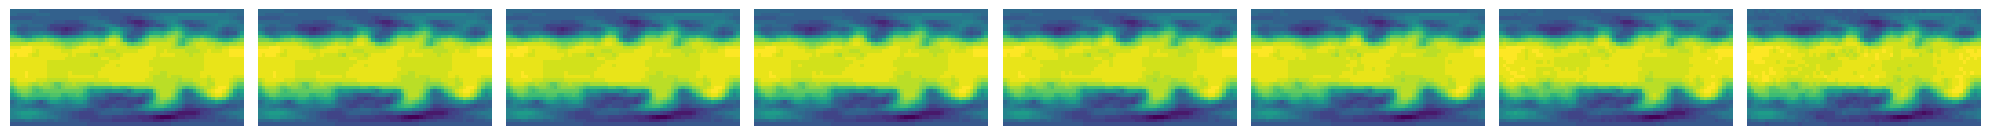

In [41]:
def plot_denoising_of_states():
    """
    Plot the denoising of random states
    """
    image =  next(iter(train_loader))[0][0,0] * std_data + mean_data

    noisy_images = []
    max_num = 8
    for i in range(max_num):

        rnd_uniform = 1 - i/(max_num-1)
        rho_inv = 1 / 7
        sigma_max_rho = 88 ** rho_inv
        sigma_min_rho = 0.02 ** rho_inv
        
        sigma = (sigma_max_rho + rnd_uniform * (sigma_min_rho - sigma_max_rho)) ** 7

        weight = (sigma ** 2 + 1 ** 2) / (sigma * 1) ** 2

        noise = torch.randn_like(image)
        noisy_image = image + sigma * noise
        
        noisy_images.append(noisy_image.cpu().detach().numpy())

    fig, axes = plt.subplots(1, max_num, figsize=(20, 4))
    for i in range(max_num):
        axes[i].imshow(noisy_images[i], cmap=cmap)
        axes[i].axis('off')

    plt.tight_layout()

    plt.savefig('noisy_images.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

plot_denoising_of_states()

##### **State:** Standard plot of ensembles

<Figure size 640x480 with 0 Axes>

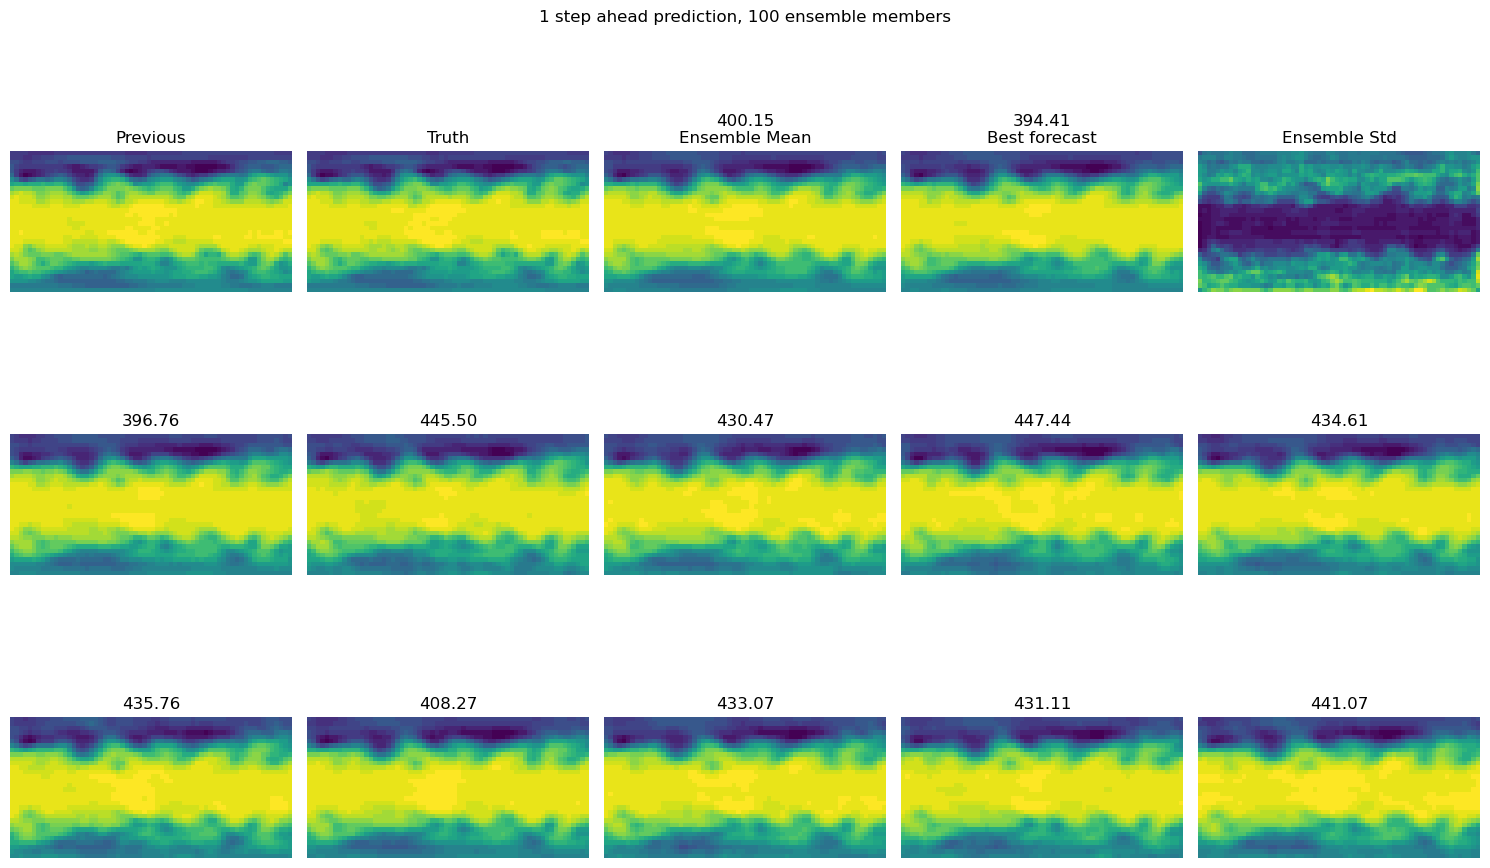

In [42]:
# Standard plot of ensembles

def ensemble_plot(model, selected_loader=val_loader, n_ens=10, sampler_fn=heun_sampler):
    
    lead_time = selected_loader.dataset.lead_time
    predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens, selected_loader, sampler_fn=sampler_fn)

    ensemble_mean = predicted_unnormalized.mean(dim=0, keepdim=True)
    ensemble_rmses = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
    ensemble_skill = calculate_RMSE(ensemble_mean, current_unnormalized).item()
    ensemble_std = predicted_unnormalized.std(dim=0)

    best_forecast = predicted_unnormalized[np.argmin(ensemble_rmses)]
    best_rmse = ensemble_rmses[np.argmin(ensemble_rmses)]

    def plot_image(ax, image, title):
        image = image.cpu().detach().numpy().reshape((current_unnormalized.shape[2],current_unnormalized.shape[3]))
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')

    plt.set_cmap('viridis')
    no_ens_rows = 2

    fig, axes = plt.subplots(1+no_ens_rows, 5, figsize=(15, 10))
    fig.suptitle(f'{lead_time} step ahead prediction, {n_ens} ensemble members')

    plot_image(axes[0,0], previous_unnormalized, "Previous")
    plot_image(axes[0,1], current_unnormalized, "Truth")
    plot_image(axes[0,2], ensemble_mean, f"{ensemble_skill:.2f}\nEnsemble Mean")
    plot_image(axes[0,3], best_forecast, f"{best_rmse:.2f}\nBest forecast")
    plot_image(axes[0,4], ensemble_std, "Ensemble Std")

    count = 0
    for i in range(no_ens_rows):
        for j in range(5):
            plot_image(axes[1+i,j], predicted_unnormalized[count], f"{ensemble_rmses[count]:.2f}")
            count+=1
    
    plt.tight_layout()
    plt.show()
    
    return ensemble_rmses, ensemble_skill


ensemble_rmses, ensemble_skill = ensemble_plot(model, selected_loader=val_loader, n_ens=100, sampler_fn=heun_sampler)


##### **State:** Forecast at single future time like GenCast

In [44]:
# We assume that the split results in same distance between all.
# Otherwise it becomes wrong when we flip it.

# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 0
t_kmax = 150
t_d = 25

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **WB_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)

        current_last = current[-1].unsqueeze(0).repeat(current.shape[0]-1, 1, 1, 1)
        current_latent = autoencoder.encoder(current_last)

        time_labels = time_label[0].flip([0])[:-1].to(device)
        
        previous_latent = autoencoder.encoder(current[:-1])
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent

        current_unnormalized = current_last * std_data + mean_data

        break

In [45]:
n_ens = 4

ensembles = []
with torch.no_grad():

    for i in range(n_ens):    
        latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)
ens_mean = ensembles.mean(dim=0)
ens_std = ensembles.std(dim=0)


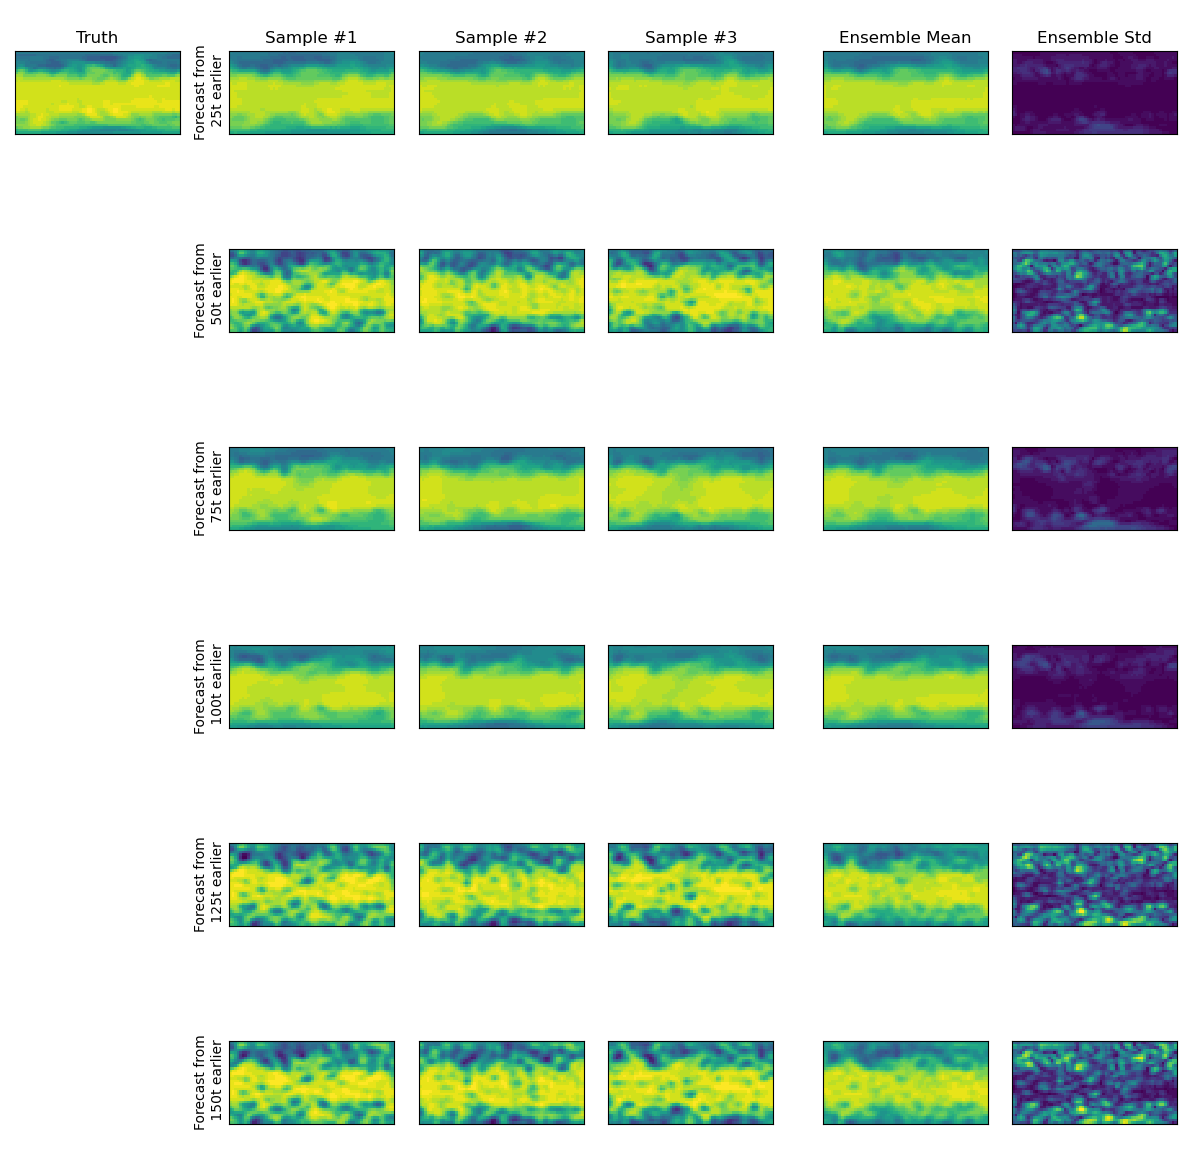

In [46]:
import matplotlib.gridspec as gridspec

def plot_image(ax, image, title=None, vmin=None, vmax=None):
    image = image.cpu().detach().numpy().reshape((image.shape[1],image.shape[2]))
    ax.imshow(image,vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    if title!=None:
        ax.set_title(title)
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

no_ens_rows = ensembles.shape[1]

cols = 6 + 2
col_width_ratios = [1, 0, 1, 1, 1, 0, 1, 1]
gs = gridspec.GridSpec(no_ens_rows, cols, width_ratios=col_width_ratios)
fig = plt.figure(figsize=(15,15))

axes = np.empty((no_ens_rows, cols), dtype=object)
for i in range(no_ens_rows):
    for j in range(cols):
        axes[i,j] = plt.subplot(gs[i,j])

max_value = ensembles[:3].max()
min_value = ensembles[:3].min()

plot_image(axes[0,0], current_unnormalized[-1], "Truth", vmin=min_value, vmax=max_value)

for j in range(1, 4):
    axes[0,j+1].set_title(f"Sample #{j}")
axes[0,6].set_title("Ensemble Mean")
axes[0,7].set_title(f"Ensemble Std")


for i in range(no_ens_rows):
    if i > 0:
        axes[i,0].axis('off')
    axes[i,1].text(1.18,0.5, f"Forecast from\n {time_labels[-(i+1)].item()}t earlier", horizontalalignment='center', verticalalignment='center', rotation=90, transform=axes[i,0].transAxes)
    
    axes[i,1].axis('off')
    axes[i,5].axis('off')

    for j in range(1, 4):
        plot_image(axes[i,j+1], ensembles[j,-(i+1)], vmin=min_value, vmax=max_value)
    plot_image(axes[i,6], ens_mean[-(i+1)], vmin=min_value, vmax=max_value)
    plot_image(axes[i,7], ens_std[-(i+1)], vmin=0, vmax=ens_std.max())


plt.savefig('large_ensemble_plot.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)
plt.show()

##### **State:** Forecast over lead time

In [47]:
t_kmin = 25
t_kmax = 150
t_d = 25

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **WB_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [48]:
n_ens = 10

ensembles = []
with torch.no_grad():

    for i in range(n_ens):    
        latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)
ens_mean = ensembles.mean(dim=0)
ens_std = ensembles.std(dim=0)


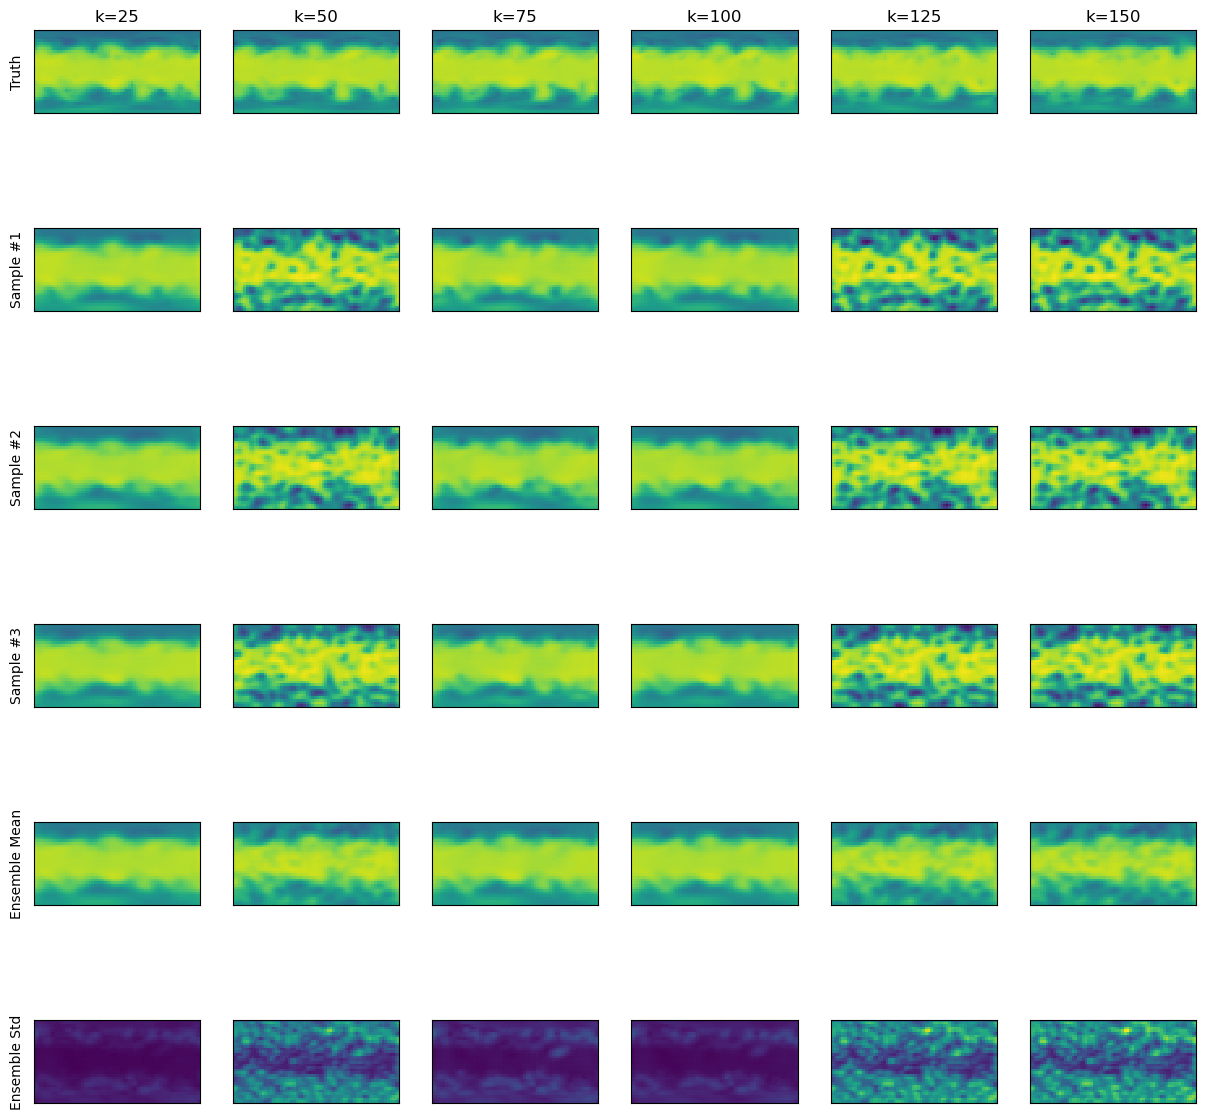

In [49]:
import matplotlib.gridspec as gridspec


def plot_image(ax, image, title=None, vmin=None, vmax=None, cmap='viridis'):
    image = image.cpu().detach().numpy().reshape((image.shape[1],image.shape[2]))
    ax.imshow(image,vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    if title!=None:
        ax.set_title(title)
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

def place_text(ax, text):
    ax.text(-0.1,0.5, text, horizontalalignment='center', verticalalignment='center', rotation=90, transform=ax.transAxes)

max_value = max([ensembles[:3].max(), current_unnormalized.max(), ens_mean.max()])
min_value = min([ensembles[:3].min(), current_unnormalized.min(), ens_mean.min()])

no_ens_rows =  ensembles.shape[1]

cols = current_unnormalized.shape[0]

gs = gridspec.GridSpec(no_ens_rows, cols)#, width_ratios=col_width_ratios)

fig = plt.figure(figsize=(15,15))#, constrained_layout=True)


axes = np.empty((no_ens_rows, cols), dtype=object)
for i in range(no_ens_rows):
    for j in range(cols):
        axes[i,j] = plt.subplot(gs[i,j])


place_text(axes[0,0], "Truth")
place_text(axes[1,0], "Sample #1")
place_text(axes[2,0], "Sample #2")
place_text(axes[3,0], "Sample #3")
place_text(axes[4,0], "Ensemble Mean")
place_text(axes[5,0], "Ensemble Std")

for i in range(cols):
    

    plot_image(axes[0,i], current_unnormalized[i], f'k={time_labels[i]}', vmin=min_value, vmax=max_value)
    
    for j in range(1, 4):
        plot_image(axes[j, i], ensembles[j-1, i], vmin=min_value, vmax=max_value)
    
    plot_image(axes[4,i], ens_mean[i], vmin=min_value, vmax=max_value)
    plot_image(axes[5,i], ens_std[i], vmin=0, vmax=ens_std.max(), cmap='viridis')


plt.savefig('long_ensemble_plot.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)
plt.show()



#### **Plot**

##### **Plot:** RMSE over time

In [ ]:
def rmse_plot(model, n_ens=1, n_batches=1, selected_loader=val_loader, sampler_fn=heun_sampler):
    model.eval()

    result = {}
    result['rmse_model'] = np.zeros(n_batches*batch_size)
    result['rmse_clim'] = np.zeros(n_batches*batch_size)

    with torch.no_grad():
        for count, (previous, current, time_label) in enumerate(tqdm(selected_loader)):
            current = current.to(device)
            time_label = time_label.to(device)
            if count >= n_batches:
                break

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, time_label[0], n_ens=n_ens, sampler_fn=sampler_fn)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            #  Note that this is kind of cheating since we are using the validation set to calculate the climatology.
            #  More realistic if we have a larger batch size.
            #climatology = previous_unnormalized.mean(dim=0, keepdim=True)

            ensemble_mean = predicted_unnormalized.mean(dim=0)

            rmse_model = calculate_RMSE(ensemble_mean, current_unnormalized)
            rmse_clim = calculate_RMSE(climatology, current_unnormalized)

            result['rmse_model'][count*batch_size:count*batch_size+rmse_model.size] = rmse_model.flatten()
            result['rmse_clim'][count*batch_size:count*batch_size+rmse_model.size] = rmse_clim.flatten()

    return result

0
1


  0%|          | 0/104991 [00:00<?, ?it/s]C:\Users\svart\AppData\Local\Temp\ipykernel_32416\542238765.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
  0%|          | 1/104991 [00:03<93:17:23,  3.20s/it]


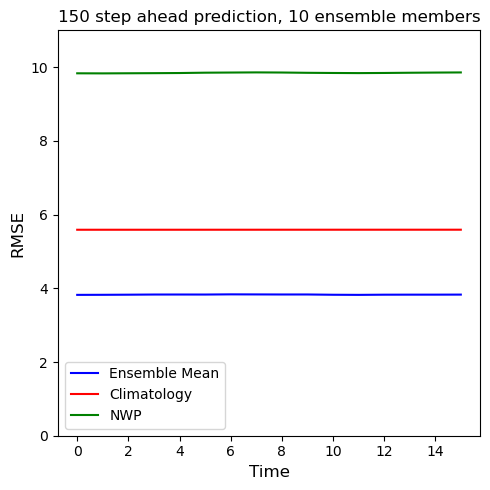

In [ ]:
lead_time = 150
batch_size = 16
val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **QG_kwargs)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

n_batches = 1

# NWP

n_val = 210000
nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{lead_time}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{lead_time}.npy')
nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)
nwp_skill = calculate_nwp_skill(n_batches=n_batches)

# Climate and skill
climatology = calculate_climatology(train_loader, n_batches=n_batches)

n_ens = 10
running_mean = 100

result = rmse_plot(model, n_ens, n_batches, selected_loader=val_loader, sampler_fn=heun_sampler)

rmse_model, rmse_clim = result['rmse_model'], result['rmse_clim']
rmse_nwp = nwp_skill[:n_batches*batch_size]

plt.figure(figsize=(5,5))
plt.title(f'{lead_time} step ahead prediction, {n_ens} ensemble members')
plt.plot(uniform_filter1d(rmse_model, size=running_mean), label='Ensemble Mean', color='b')
plt.plot(uniform_filter1d(rmse_clim, size=running_mean), label='Climatology', color='r')
plt.plot(uniform_filter1d(rmse_nwp, size=running_mean), label='NWP', color='g')
plt.ylim(0,11)
plt.xlabel('Time', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def rmse_density_plot(ensemble_rmses, ensemble_skill):
    plt.figure(figsize=(6,6))
    plt.hist(ensemble_rmses, bins=100)
    plt.axvline(ensemble_skill, color='red', linestyle='--')
    plt.xlabel('Ensemble RMSEs')
    plt.ylabel('Density')
    plt.title('Density Plot of Ensemble RMSEs')
    plt.show()

rmse_density_plot(ensemble_rmses, ensemble_skill)

##### **Plot:** Spread vs time

In [ ]:
# Fixed k sampling
# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 10
t_kmax = 150
t_d = 10
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **QG_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

n_batches = 1

spread_list = []
skill_list = []
ratio_list = []

for i in tqdm(range(n_batches)):
        
    model.eval()  # Set model to evaluation mode

    n_ens = 10

    with torch.no_grad():
        for previous, current, time_label in (val_time_series_loader):
            current = current.to(device).permute(1,0,2,3)
            previous = previous.to(device)

            current_latent = autoencoder.encoder(current)

            time_labels = time_label[0].to(device)
            
            previous_latent = autoencoder.encoder(previous)
            
            scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
            target_latent =  (current_latent - previous_latent) / scaling
            
            class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            break


    ensembles = []
    with torch.no_grad():
        for i in tqdm(range(n_ens)):    
            latents = torch.randn_like(class_labels[0].unsqueeze(0), device=device).repeat(class_labels.shape[0], 1, 1, 1)

            predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
            predicted_latent = previous_latent + predicted_residuals * scaling

            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unnormalized = predicted * std_data + mean_data

            ensembles.append(predicted_unnormalized)

    ensembles = torch.stack(ensembles)
    ens_mean = ensembles.mean(dim=0)


    spreads = []
    skills = []

    for i in range(len(time_labels)):
        truth = current_unnormalized[i]
        predicted = ens_mean[i]
        ensemble = ensembles[:, i]

        skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
        spreads.append(spread[0])
        skills.append(skill[0])
    
    spread_list.append(spreads)
    skill_list.append(skills)
    ratio_list.append(np.array(spreads)/np.array(skills))

spread_list = np.array(spread_list)
skill_list = np.array(skill_list)
ratio_list = np.array(ratio_list)
time_labels = time_labels.cpu().detach().numpy()

100%|██████████| 1/1 [00:19<00:00, 19.67s/it]


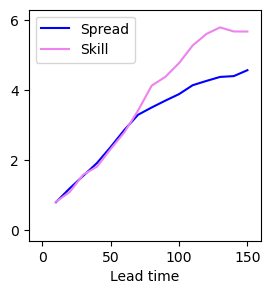

In [ ]:
spreads = spread_list.mean(axis=0)
skills = skill_list.mean(axis=0)

plt.figure(figsize=(3,3))
plt.xlabel('Lead time')

plt.xticks([0,50,100,150])
plt.xlim([-10,160])
plt.yticks([0,2,4,6])
plt.ylim(0-0.3, 6+0.3)

plt.plot(time_labels, uniform_filter1d(spreads, size=1), label='Spread', color='#0000FF')
plt.plot(time_labels, uniform_filter1d(skills, size=1), label='Skill', color='#EE82EE')

plt.legend()

plt.savefig(f'skill_spread_{lead_time}_{n_ens}.pdf', dpi=100, format='pdf', bbox_inches='tight')

##### **Plot:** Rank Histogram

In [74]:
def generate_ensembles(n_ens, n_batches, selected_loader=val_loader):
    model.eval()

    ensembles = []
    truths = []

    with torch.no_grad():
        for count, (previous, current, time_label) in enumerate(tqdm(selected_loader, total=n_batches)):
            if count >= n_batches:
                break
            current = current.to(device)

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, time_label[0], n_ens=n_ens, sampler_fn=heun_sampler)
            current_unnormalized = current * std_data + mean_data

            ensembles.append(predicted_unnormalized)
            truths.append(current_unnormalized)

    ensembles = torch.cat(ensembles, dim=1)
    truths = torch.cat(truths, dim=0)
    return ensembles, truths


lead_time = 150
batch_size = 16
val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **QG_kwargs)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

n_ens = 1
n_batches = 1

ensembles, truths = generate_ensembles(n_ens, n_batches, selected_loader=val_loader)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\svart\AppData\Local\Temp\ipykernel_32416\542238765.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


In [75]:
# Rank Histogram

def calculate_rank(predicted, target):
    ranks = (target[None, :] < predicted).sum(axis=0)
    return ranks

def rank_histogram(pixel, ensembles, truths):

    pixel_x, pixel_y = pixel
    
    ensemble = ensembles[:, :, 0, pixel_x, pixel_y]
    target = truths[:, 0, pixel_x, pixel_y]

    rank = calculate_rank(ensemble, target)

    return rank.cpu().detach().numpy()

1 members, 16 samples


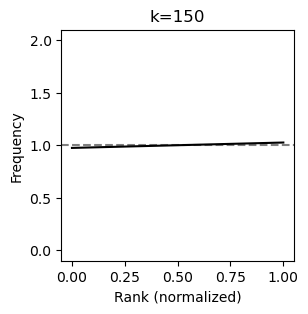

In [81]:
# New look

ranks = np.zeros(n_ens+1)
for i in range(0, truths.shape[2]):
    for j in range(0, truths.shape[3]):
        pixel = (i,j)
        rank = rank_histogram(pixel, ensembles, truths)
        freq = np.bincount(rank, minlength=n_ens+1)
        ranks += freq

print(f'{n_ens} members, {n_batches*batch_size} samples')
plt.figure(figsize=(3,3))
plt.title(f'k={lead_time}')
plt.plot(np.linspace(0,1,n_ens+1), ranks*(n_ens+1)/(sum(ranks)), color='black')
plt.xlabel('Rank (normalized)')
plt.ylabel('Frequency')
plt.ylim(-0.1,2.1)
plt.yticks([0,0.5,1,1.5,2])
plt.xticks([0,0.25,0.5,0.75,1])
plt.axhline(1, color='k', linestyle='--', alpha=0.5)

plt.savefig(f'rank_histogram_{lead_time}_{n_ens}_{n_batches*batch_size}.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)

(29, 12)


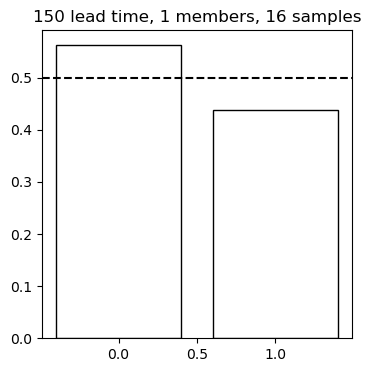

In [83]:
pixel = (np.random.randint(0, truths.shape[2]), np.random.randint(0, truths.shape[3]))
print(pixel)
#pixel = (1,33)
ranks = np.zeros(n_ens+1)
rank = rank_histogram(pixel, ensembles, truths)
freq = np.bincount(rank, minlength=n_ens+1)
ranks += freq

plt.figure(figsize=(4,4))
plt.title(f'{lead_time} lead time, {n_ens} members, {n_batches*batch_size} samples')
plt.bar(np.arange(n_ens+1), ranks/(sum(ranks)), facecolor='white', edgecolor='black')
plt.axhline(1/(n_ens+1), color='k', linestyle='--')

##### **Plot:** Likelihood Estimation

OBS: We can not do the same boxplots as before since we sample at the same time as calculating likelihood
And also not evaluate the effect of eps_multiplier

In [ ]:
def generate_and_estimate_likelihood(model, n_ens=10, selected_loader = val_loader, sampler_fn=likelihood_sampler, num_steps=20, eps_multiplier=1):

    model.eval()

    for previous, current, time_label in selected_loader:
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break

    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        latents = torch.randn_like(class_labels, device=device)

        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

    predicted_unnormalized_ensemble = torch.zeros((n_ens, 1, previous.size(1), previous.size(2), previous.size(3)), device=device)
    likelihood_ensemble = np.zeros(n_ens)
    rmse_ensemble = np.zeros(n_ens)
    mae_ensemble = np.zeros(n_ens)

    for j in tqdm(range(n_ens)):
        with torch.no_grad():
            latent = latents[j].unsqueeze(0)
            class_label = class_labels[j].unsqueeze(0)
            time_labels = time_label[0].repeat(n_ens).to(device)

            predicted_residuals, likelihood  = sampler_fn(model, 
                                    latent, 
                                    class_label,
                                    time_labels / max_lead_time,
                                    eps_multiplier=eps_multiplier,
                                    num_steps=num_steps,
                                    sigma_max=80, sigma_min=0.03, rho=7, 
                                    S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
            
            predicted_latent = previous_latent + predicted_residuals * residual_scaling(time_labels)
            
            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unnormalized = predicted * std_data + mean_data
            predicted_unnormalized_ensemble[j] = predicted_unnormalized
            likelihood_ensemble[j] = likelihood.item()

            # ----
            ensemble_rmse = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
            ensemble_mae = calculate_MAE(predicted_unnormalized, current_unnormalized).flatten()
            
            rmse_ensemble[j] = ensemble_rmse.item()
            mae_ensemble[j] = ensemble_mae.item()
            print(f"Likelihood {j}: {likelihood.item():.0f}, RMSE {j}: {rmse_ensemble[j]:.2f}, MAE {j}: {mae_ensemble[j]:.2f}")
        
    return predicted_unnormalized_ensemble, current_unnormalized, likelihood_ensemble, rmse_ensemble, mae_ensemble

100%|██████████| 1/1 [00:11<00:00, 11.73s/it]

Likelihood 0: 3073, RMSE 0: 6.07, MAE 0: 2.53


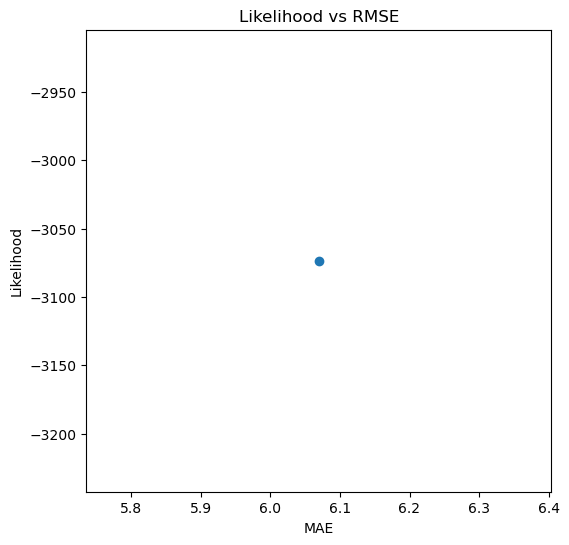

In [ ]:
n_ens = 1
eps_multiplier = 1
num_steps = 20

predicted_unnormalized_ensemble, current_unnormalized, likelihood_ensemble, rmse_ensemble, mae_ensemble = generate_and_estimate_likelihood(model, n_ens=n_ens, selected_loader = val_loader, sampler_fn=likelihood_sampler, num_steps=num_steps, eps_multiplier=eps_multiplier)

plt.figure(figsize=(6,6))
plt.xlabel('MAE')
plt.ylabel('Likelihood')
plt.title('Likelihood vs RMSE')
plt.plot(rmse_ensemble, -likelihood_ensemble, marker='o', linestyle='')

#### **Animation**

##### **Animation:** Direct forecasting

In [50]:
t_kmin = 1
t_kmax = 36
t_d = 1

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **WB_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [51]:
n_ens = 10

latents_list = []
ensembles_list = []

for i in range(n_ens): 
    latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
    latents_list.append(latents)

latents_list = torch.stack(latents_list)

In [52]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():

    for i in range(n_ens):
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)

In [53]:
dt = len(time_labels)
dx = ensembles.shape[3]
dy = ensembles.shape[4]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
forecasts = ensembles.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))

ens_mean = forecasts.mean(axis=0)
ens_std = forecasts.std(axis=0)

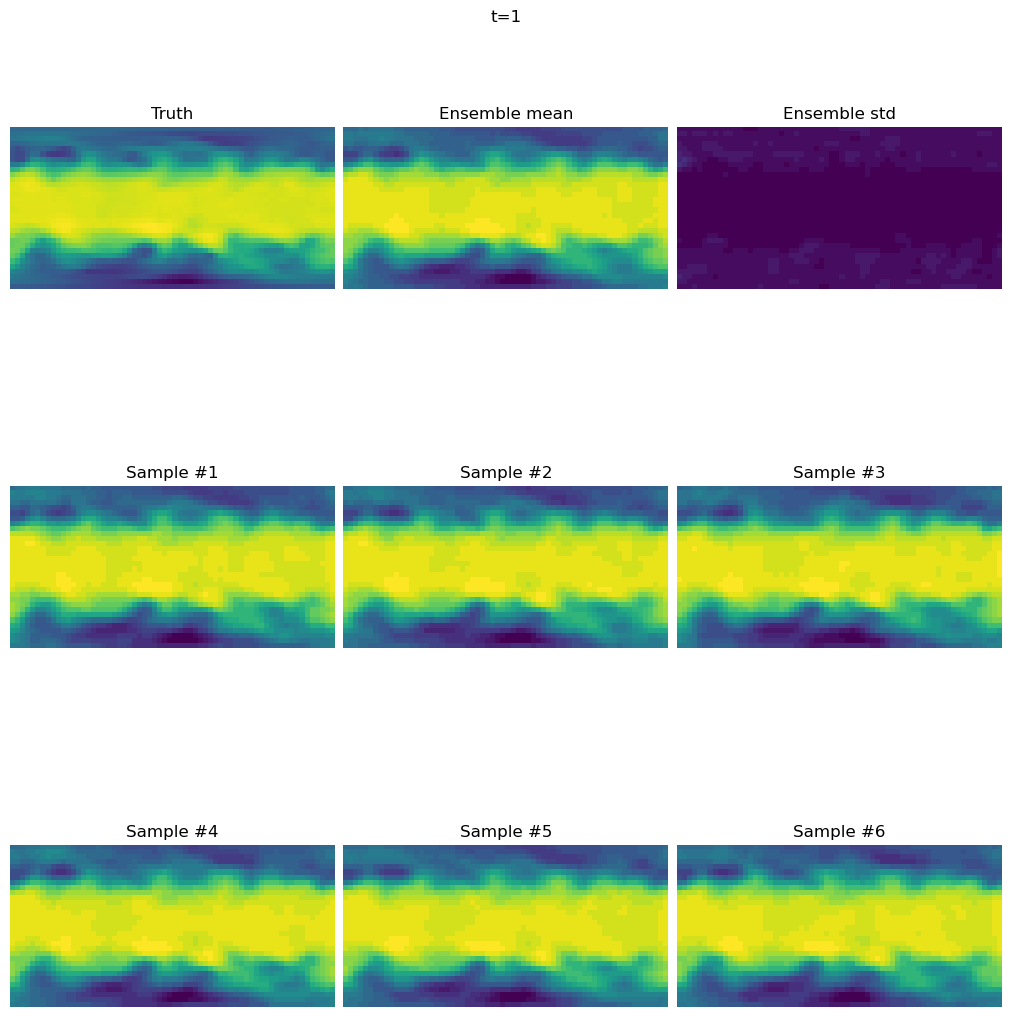

In [59]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0]))
    elif i == 1:
        images.append(ax.imshow(ens_mean[0], cmap=cmap))
    elif i == 2:
        images.append(ax.imshow(ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max()))
    else:
        images.append(ax.imshow(forecasts[i-3,0], cmap=cmap))
        ax.set_title(f'Sample #{i-2}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(ens_mean[n])
        elif i == 2:
            im.set_array(ens_std[n])
        else:
            im.set_array(forecasts[i-3,n])

    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')
    title2.set_text('Ensemble mean')
    title3.set_text('Ensemble std')

    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=80)

#anim.save('animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

##### **Animation:** Iterative vs Direct Forecasting

In [ ]:
t_kmin = 10
t_kmax = 150
t_d = 10

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **QG_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [ ]:
n_ens = 3

latents_list = []
ensembles_list = []

for i in range(n_ens): 
    latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
    latents_list.append(latents)

latents_list = torch.stack(latents_list)

In [ ]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():

    for i in range(n_ens):
        # Direct  
        #latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)

    # Autoreg
    latents = latents_list[:,0]
    prev_pred = class_labels[0].repeat(n_ens, 1, 1, 1)
    time_label = time_labels[0].repeat(n_ens)
    scale = residual_scaling(time_label).view(-1, 1, 1, 1)

    for i in range(roll_outs):
        predicted_ar_residuals = heun_sampler(model, latents, prev_pred, time_label/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_ar_latent = prev_pred + predicted_ar_residuals * scale
        
        predicted_ar = autoencoder.decoder(predicted_ar_latent.to(torch.float32))
        
        prev_pred = predicted_ar_latent
        
        predicted_unnormalized_ar = predicted_ar * std_data + mean_data
        ensembles_ar.append(predicted_unnormalized_ar)


ensembles = torch.stack(ensembles)
ensembles_ar = torch.stack(ensembles_ar).permute(1,0,2,3,4)


In [ ]:
dt = len(time_labels)
dx = ensembles.shape[3]
dy = ensembles.shape[4]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
forecasts_dir = ensembles.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))
forecasts_ar = ensembles_ar.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))

ens_mean_dir = forecasts_dir.mean(axis=0)
ens_std_dir = forecasts_dir.std(axis=0)

ens_mean_ar = forecasts_ar.mean(axis=0)
ens_std_ar = forecasts_ar.std(axis=0)

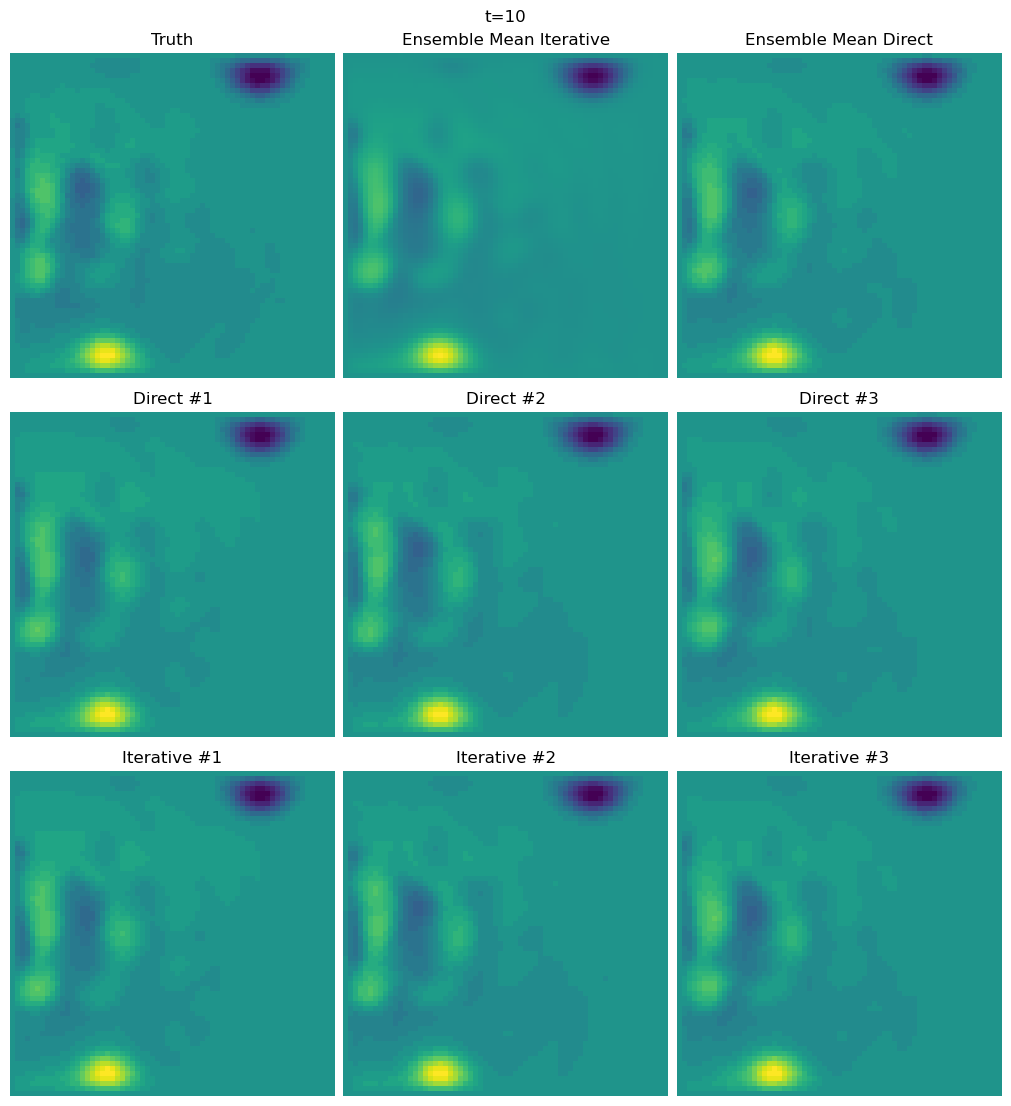

In [ ]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0], cmap=cmap))
    elif i == 1:
        images.append(ax.imshow(ens_mean_ar[0]))
    elif i == 2:
        images.append(ax.imshow(ens_mean_dir[0], cmap=cmap))
    elif i <=5:
        images.append(ax.imshow(forecasts_dir[i-3,0], cmap=cmap))
        ax.set_title(f'Direct #{i-2}')
    else:
        images.append(ax.imshow(forecasts_ar[i-6,0], cmap=cmap))
        ax.set_title(f'Iterative #{i-5}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            pass
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(ens_mean_ar[n])
        elif i == 2:
            im.set_array(ens_mean_dir[n])
        elif i < 6:
            im.set_array(forecasts_dir[i-3,n])
        else:
            im.set_array(forecasts_ar[i-6,n])


    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')
    title2.set_text('Ensemble Mean Iterative')
    title3.set_text('Ensemble Mean Direct')

    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

#anim.save('animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

##### **Animation:** Interpolation between latent states

In [144]:
t_kmin = 1
t_kmax = 150
t_d = 1

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **QG_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [150]:
n_ens = 6

latents1 = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
latents2 = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)

alphas = np.linspace(0, 1, n_ens)

def interpolate_latents(alpha):
    return np.sqrt(1-alpha)*latents1 + np.sqrt(alpha)*latents2

latents_list = []

for alpha in alphas:
    latents_list.append(interpolate_latents(alpha))

latents_list = torch.stack(latents_list)

In [152]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():

    for i in range(n_ens):
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)

In [153]:
dt = len(time_labels)
dx = ensembles.shape[3]
dy = ensembles.shape[4]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
forecasts = ensembles.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))

ens_mean = forecasts.mean(axis=0)
ens_std = forecasts.std(axis=0)

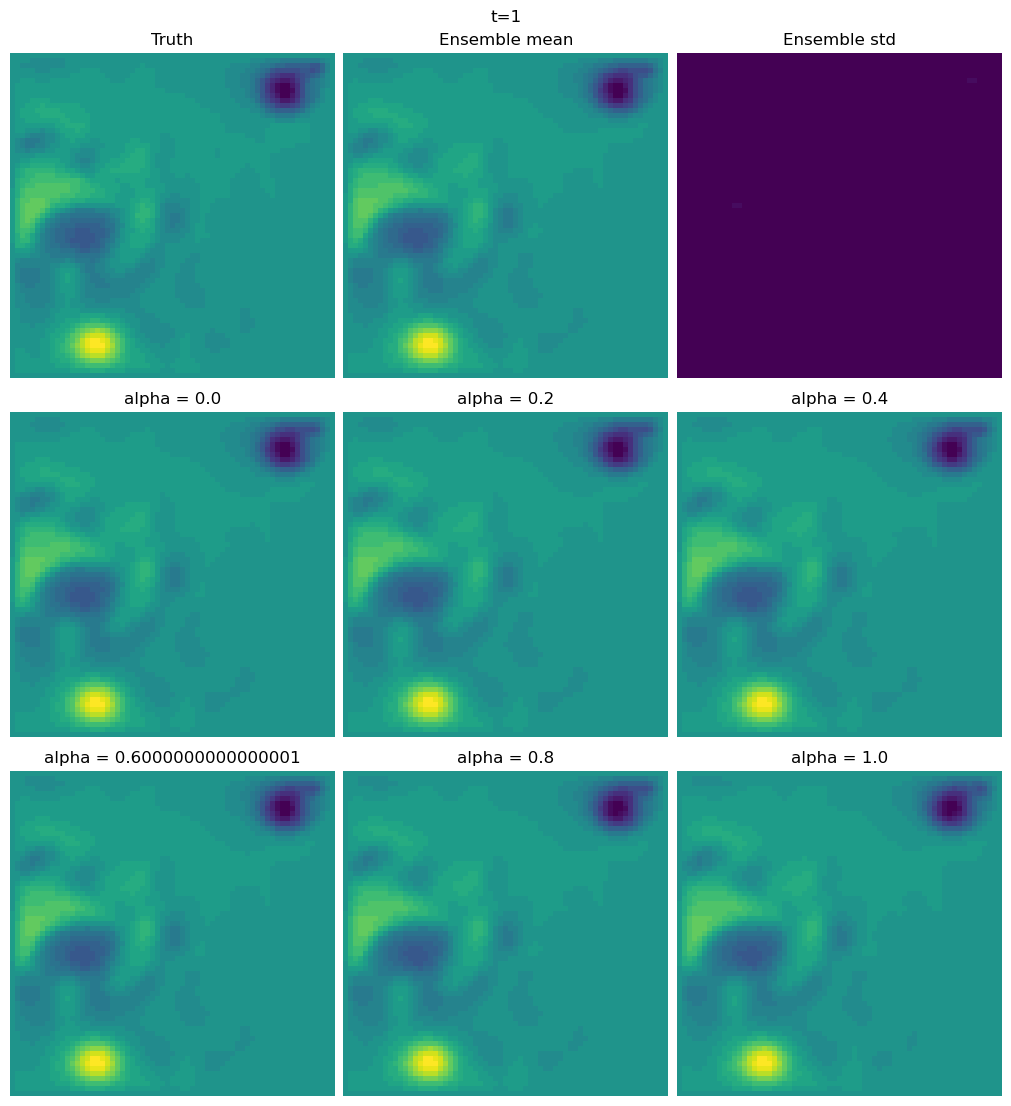

In [155]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0], cmap=cmap))
    elif i == 1:
        images.append(ax.imshow(ens_mean[0], cmap=cmap))
    elif i == 2:
        images.append(ax.imshow(ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max()))
    else:
        images.append(ax.imshow(forecasts[i-3,0], cmap=cmap))
        ax.set_title(f'alpha = {alphas[i-3]}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(ens_mean[n])
        elif i == 2:
            im.set_array(ens_std[n])
        else:
            im.set_array(forecasts[i-3,n])

    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')
    title2.set_text('Ensemble mean')
    title3.set_text('Ensemble std')

    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=50)

#anim.save('animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())